In [1]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp

read icdata
read uptdata
read eadata
read mspdata


In [2]:
len(msdec)
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)
len(msdec)
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e6))
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1

gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * (enus[i]**gamma))


    return np.trapz(wt_ac_temp, enus)

wt_vec = psr_wt_sing_gamma(range(p), -1, 0)
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
if f'wt_acc_{len(enus)}_bins_C_wt.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_C_wt.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
    

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_C_wt.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all pulsars and seasons and gamma")
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2

@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        # tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)


# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi_C.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi_C.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi_C.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)


arr = np.zeros(10, dtype=np.float64)


@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]

        
    l = msdec_bin_indices[psrno]
     
        
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus)     #in s cm2 eV



def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0
    ns_hat_wt_dist = 0
    ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):

        ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)
        ns_hat_wt += ns_hat
        ns_hat_wt_dist += np.dot(w_models[1]/ np.sum(w_models[1]) , ns_hat)
        ns_hat_wt_s1400 += np.dot(w_models[2]/ np.sum(w_models[2]), ns_hat)
    return np.array([np.mean(ns_hat_wt), ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
        np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")




@njit(nogil=True)
def TS_for_all_psrs2(nsa):  
    return Ts_arr2(nsa, t2mp, all_Bi, Ns) 


@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


phio = np.logspace(-38, -20, 1000)
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS = []
for ws in prange(3):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')



all_TSS = np.array(all_TSS, dtype=np.float64)


for w in range(3):
    for g in range(len(gamma_arr)):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
        # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
        
    print('wt\n')

with open(altier_path[0] + f'all_TSS_{len(enus)}_bins_C_wt.pkl', 'wb') as f:
    pickle.dump(all_TSS, f)
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)



Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...


Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  1000000
Loading all_Si_ws_g_s from pickle
Loaded all_Si_ws_g_s from pickle with nbins = 1000000
Loading all_Bi from pickle...
Loaded all_Bi from pickle

Calculating ns_HAT for all gamma and weighting schemes...



100%|██████████| 10/10 [02:48<00:00, 16.86s/it]



Calculationed ns_HAT for all gamma and weighting schemes

CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 125.65it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 130.98it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 132.84it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 127.32it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 132.07it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 131.22it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 130.64it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 129.35it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 133.91it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 131.60it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 132.42it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 127.65it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS
-7780560.744665362 12.159394755327114
-6226437.4429535465 14.84248440093616
-9051078.190388579 16.109925905354988
-7428006.874868119 15.976216679499455
wt

-6952846.525708904 1.2955111038574936
-5945891.9962468175 3.178236434352972
-11089721.605992446 4.667489574165592
-7888992.3520326875 4.902075630156322
wt

-7155899.896173775 4.653642835126385
-7499304.524981873 6.823778685454639
-6751109.419719051 7.383824559023069
-7011116.1075465 7.272258677549487
wt



In [27]:
phio

array([1.00000000e-38, 1.04236067e-38, 1.08651577e-38, 1.13254132e-38,
       1.18051653e-38, 1.23052400e-38, 1.28264983e-38, 1.33698374e-38,
       1.39361927e-38, 1.45265393e-38, 1.51418933e-38, 1.57833141e-38,
       1.64519059e-38, 1.71488197e-38, 1.78752553e-38, 1.86324631e-38,
       1.94217468e-38, 2.02444651e-38, 2.11020343e-38, 2.19959307e-38,
       2.29276931e-38, 2.38989257e-38, 2.49113003e-38, 2.59665597e-38,
       2.70665207e-38, 2.82130768e-38, 2.94082017e-38, 3.06539530e-38,
       3.19524751e-38, 3.33060034e-38, 3.47168682e-38, 3.61874981e-38,
       3.77204249e-38, 3.93182876e-38, 4.09838367e-38, 4.27199397e-38,
       4.45295851e-38, 4.64158883e-38, 4.83820966e-38, 5.04315949e-38,
       5.25679112e-38, 5.47947234e-38, 5.71158648e-38, 5.95353313e-38,
       6.20572881e-38, 6.46860766e-38, 6.74262224e-38, 7.02824426e-38,
       7.32596543e-38, 7.63629826e-38, 7.95977700e-38, 8.29695852e-38,
       8.64842328e-38, 9.01477631e-38, 9.39664831e-38, 9.79469667e-38,
      

In [25]:
e2dfde = 1e28 * dfde(1e14, gamma_arr, 1)

In [28]:
e2dfde

array([1.e+28, 1.e+28, 1.e+28, 1.e+28])

In [30]:
for w in range(3):
    for g in range(3):
        print(w, g+1)
        print(max(all_TSS[w][g+1]))
        print(e2dfde[g+1]/1e9 * phio[np.argmax(all_TSS[w][g+1])])

0 1
14.84248440093616
0.00012052609368708414
0 2
16.109925905354988
6.205728806776488e-05
0 3
15.976216679499455
1.180516528568803e-05
1 1
3.178236434352972
0.00018249932448161505
1 2
4.667489574165592
9.794696670695385e-05
1 3
4.902075630156322
1.86324631193156e-05
2 1
6.823778685454639
0.00018249932448161505
2 2
7.383824559023069
8.648423275731744e-05
2 3
7.272258677549487
1.5783314056521197e-05


In [41]:
tetetet = [e2dfde[gamma]/1e9 * phio for gamma in range(len(e2dfde))]

In [47]:
tetetet[1][np.argmax(all_TSS[0][2])]

6.205728806776488e-05

In [46]:
all_TSS.shape

(3, 4, 1000)

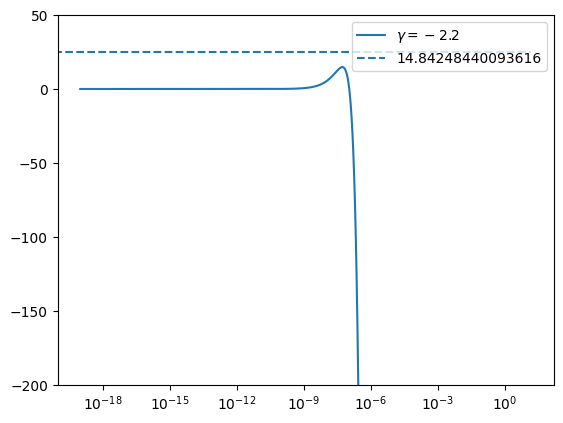

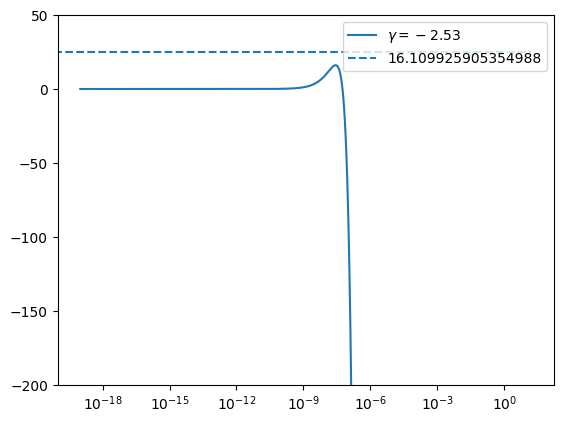

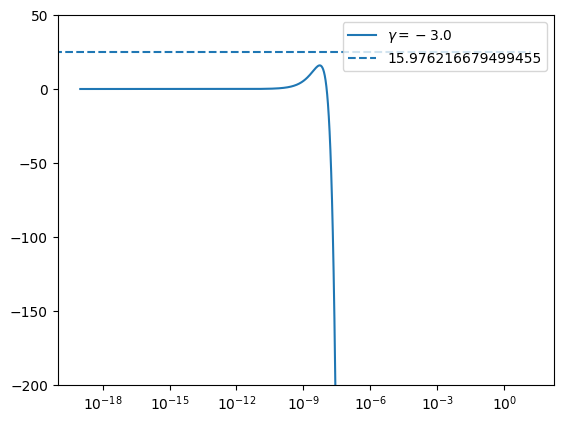

In [59]:
for i in range(3):
    plt.plot(phio* 1e19 * dfde(1e14, gamma_arr[i+1], 1), all_TSS[0][i+1], label=r'$\gamma = {}$'.format(gamma_arr[i+1]))
    plt.xscale('log')
    # plt.plot(phio, tetetet[i+1], label=r'$\gamma = {}$'.format(gamma_arr[i+1]))
    plt.hlines(25, 0, max(all_TSS[0][i+1]), linestyles='dashed', label=max(all_TSS[0][i+1]))
    plt.ylim(-200, 50)
    plt.legend()
    plt.show()


TS_vs_E2dfde_all_w_model_bins=1000000_C_wt.png
DONE


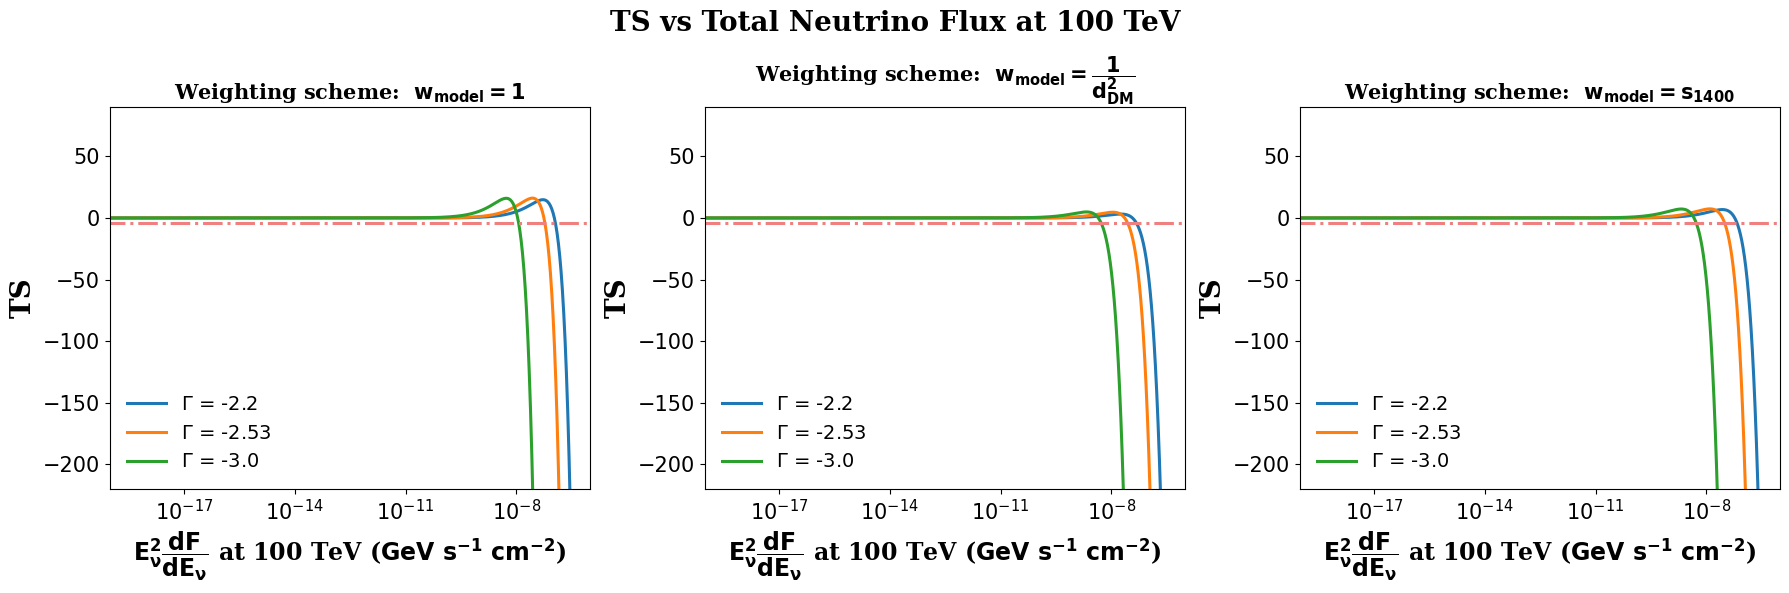

In [61]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }

fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in [ 1, 2, 3]:#range(4):
    
    for i in range(3):
        axs[i].plot( 1e28 * dfde(1e14, gamma_arr[gamma], 1) *phio /1e9, all_TSS[i][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV

    

axs[0].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
axs[1].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
axs[2].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


for i in range(3):
    
    axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')
    axs[i].hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$)', fontdict=axesfont)
    axs[i].set_ylabel('TS', fontdict=axesfont, fontsize=20)
    axs[i].xaxis.set_tick_params(labelsize=15)
    axs[i].yaxis.set_tick_params(labelsize=15)
    
    axs[i].set_ylim(-220, 90)
    axs[i].set_xlim(0.95e-19, 1e-6)

plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=20, fontfamily='serif')

plt.tight_layout()
plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}_C_wt.pdf')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}_C_wt.png\nDONE')

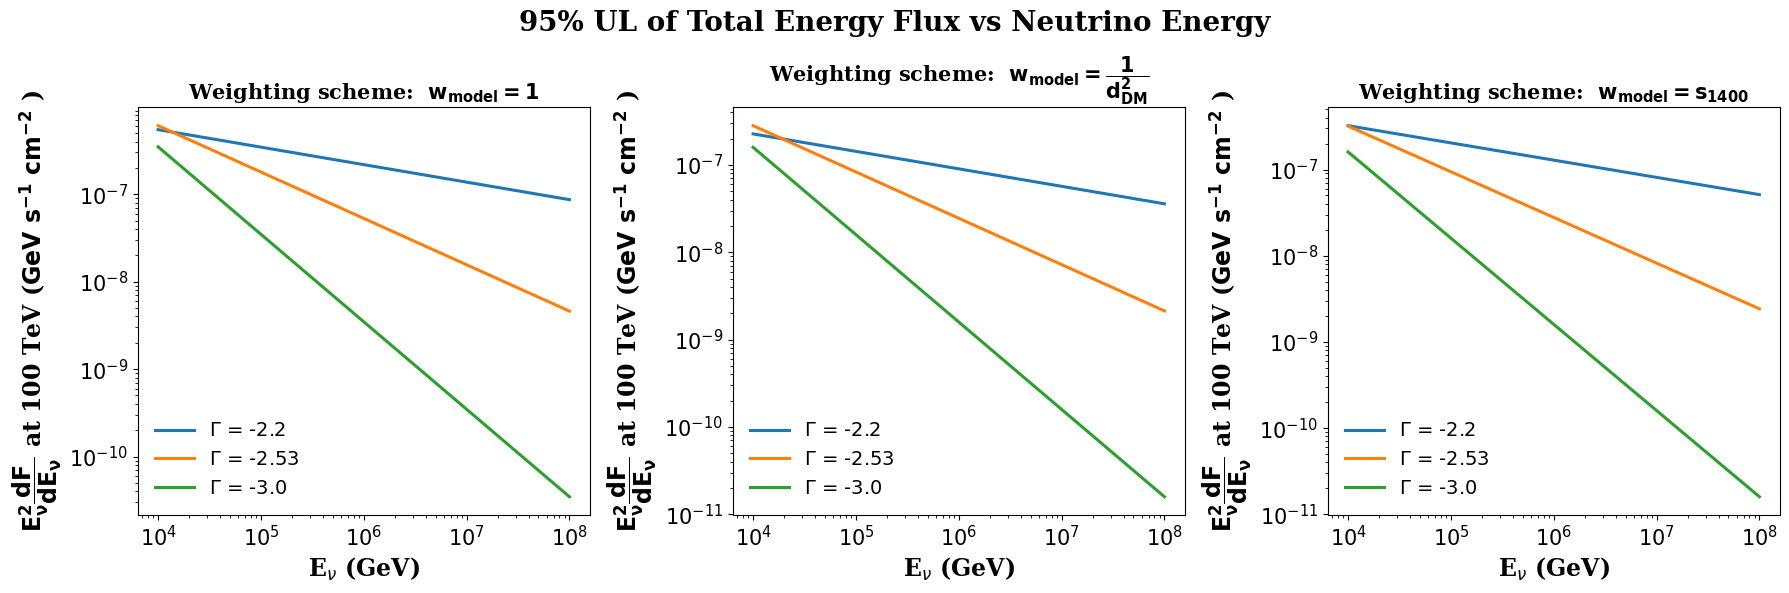

In [62]:

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']
all_TSS.shape
all_TSS.shape


tete = np.float64('2.543345761304638e-23 9.396648314954749e-24 1.4526539259467783e-24 2.3408272761782943e-23 8.296958520834915e-24 1.2305240043592616e-24 1.61141427725301e-23 5.711586478126447e-24 8.470868266557419e-25'.split(' '))


all_UL = []
for ws in range(3):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL.append(ul_all_gamma)
e2dfde = all_e_UL[1]
# plt.style.use('default')

#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1,3, figsize=(18, 6))



for i in range(3):
    for gamma in range(1, len(gamma_arr)):

        axs[i].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[i][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV

    
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
    axs[i].set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ )', fontdict=axesfont)
    axs[i].xaxis.set_tick_params(labelsize=15)
    axs[i].yaxis.set_tick_params(labelsize=15)
    
    axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')


axs[0].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
axs[1].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
axs[2].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
plt.tight_layout()
plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}_C_wt.pdf')
plt.show()